# DS 4400 HW2

Christopher Dilger

Output:
DILGER_HW2.pdf

## Problem 1 [Logistic Regression]



In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from IPython.display import display, Math

#Read in data using the pandasreader
#Use pandas dataframe manipulation to sample 75% training and 25% testing

headers = []
with open('headers.txt') as f:
    for line in f:
        headers.append(line.split(' ')[0])
    
df = pd.read_csv('spambase.txt', header=None, names = headers, index_col = False)

train=df.sample(frac=0.75,random_state=200)
test = df.drop(train.index)

lg = LogisticRegression(solver='lbfgs')
lg.fit(train.loc[:,[x for x in train.columns.values if x != 'spam' and x != 'predict']], 
                                                        train.loc[:,'spam'])
test['predict'] = None
for index in test.index:
    predarry = np.array(test.loc[index,[x for x in train.columns.values if x != 'spam' and x != 'predict']])
    test.loc[index,'predict'] = lg.predict(predarry.reshape(1, -1))

#print(train.loc[:,'predict'])
#print(len(val))
#print(len(train.loc[:,[x for x in train.columns.values if x != 'spam']]))
cm = confusion_matrix(test.loc[:,'spam'], test.loc[:,'predict'])
display(cm)
tn, fp, fn, tp = cm.ravel()

print("True Positives: {}".format(tp))
print("False Positives: {}".format(fp))
print("False Negatives: {}".format(fn))
print("True Negatives: {}".format(tp))

display(Math("Precision = {:.4f}\\\\ Recall = {:.4f} \\\\ Accuracy = {:.4f} \\\\ F_1 = {:.4f} \\\\ \epsilon= {:.4f}".format(tp/(tp+fp), tp/(tp+fn), (tp+tn)/(tp+tn+fp+fn), 1/((1/tp/(tp+fp))+(1/(tp/(tp+fn)))), 1-(tp+tn)/(tp+tn+fp+fn) )))

#print(lg.predict(np.array(train.loc[1,[x for x in train.columns.values if x != 'spam' and x != 'predict']]).reshape(1, -1)))

array([[652,  44],
       [ 49, 405]], dtype=int64)

True Positives: 405
False Positives: 44
False Negatives: 49
True Negatives: 405


<IPython.core.display.Math object>

In [ ]:
b) Coefficients of the model:
    

In [3]:
coefs = pd.DataFrame(lg.coef_[0], headers[:-1], columns=['coefficients'])
coefs.sort_values(by=['coefficients'])
#    print( headers[i], lg.coef_[0][i])
def find_classes(test, thresholds):
    temp = pd.DataFrame()
    for index in test.index:
        predarry = np.array(test.loc[index,[x for x in train.columns.values if x != 'spam' and x != 'predict']])
        temp.loc[index,'p-spam'] = lg.predict_proba(predarry.reshape(1, -1))[0][0]       
    some_storage = pd.DataFrame()
    some_storage = some_storage.assign(spam = pd.Series(test.loc[:,'spam']))
            
    for threshold in thresholds:
        for index in test.index:
            some_storage.loc[index,threshold] = int(temp.loc[index, 'p-spam'] > threshold)
            
    return some_storage
    
find = find_classes(test, [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
accuracy = pd.DataFrame()
for column in find.columns[1:]:
    #find the accuracy of the column
    cm = confusion_matrix(find.loc[:,'spam'], find.loc[:,column])
    tn, fp, fn, tp = cm.ravel()
    #append the accuracy to the accuracy column of the accuracy df at row -> column
    accuracy.loc[column, 'accuracy'] = (tp+tn)/(tp+tn+fp+fn)
display(accuracy.plot())

It seems that the largest 3 were, the frequency of the word 'george', which was correlated with not being spam, 'hp' was also an indicator of not being spam, whilst 'free' was a strong indicator that the email would be spam. The capital run length was the weakest predictor.

## Problem 2

In this problem, you will use existing packages of your choice for training and testing various classifiers,
and then compare them. You will use the same SPAMBASE dataset.
Split the original data into 75% for training and 25% for testing (chosen at random). Train the following
classifiers using the training data:
1. Logistic regression
2. LDA
3. kNN
4. Decision tree




1. Experiment with different values of k for kNN and report 2 metrics: accuracy and error. Choose the
value of k that gives the highest accuracy.
2. Print the accuracy and error metrics for all 4 classifiers. Which model is performing best? Which
one is performing worst? Write down some observations.
3. Generate a graph that includes 4 ROC curves (one for each of the 4 classifiers). Compute the Area
Under the Curve (AUC) metric for all 4 classifiers.

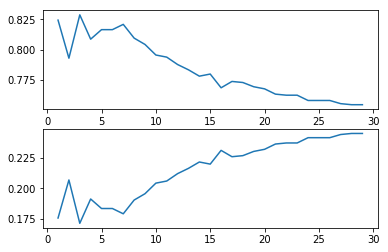

In [48]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

train.data = df.sample(frac=0.75,random_state=200)
test.data = df.drop(train.data.index)

train.x = train.data.iloc[:,0:57]
train.y = train.data['spam']

test.x = test.data.iloc[:,0:57]
test.y = test.data['spam']

lg = LogisticRegression()
lg.fit(train.x, train.y)

lda = LinearDiscriminantAnalysis()
lda.fit(train.x, train.y)

dt = DecisionTreeClassifier()
dt.fit(train.x, train.y)

kacc = []
kerr = []
kvals = range(1, 30)
for k in kvals:
    knn = KNeighborsClassifier(k)
    knn.fit(train.x, train.y)
    
    #Predict and record accuracy metrics
    
    cm = confusion_matrix(knn.predict(test.x), test.y)
    tn, fp, fn, tp = cm.ravel()
    kacc.append((tp+tn)/np.sum(cm.ravel()))
    kerr.append(1-(tp+tn)/np.sum(cm.ravel()))

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(kvals, kacc)
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(kvals, kerr)

Here we see the best accuracy at K=3


In [56]:
knn = KNeighborsClassifier(3)
knn.fit(train.x, train.y)

for model in [lg, knn, lda, dt]:
    cm = confusion_matrix(model.predict(test.x), test.y)
    tn, fp, fn, tp = cm.ravel()
    acc = (tp+tn)/np.sum(cm.ravel())
    print("{} \n Model accuracy = {:.4f}, error = {:.4f}\n".format(str(model).split('(')[0], acc, 1- acc ))
    

LogisticRegression 
 Model accuracy = 0.9322, error = 0.0678

KNeighborsClassifier 
 Model accuracy = 0.8287, error = 0.1713

LinearDiscriminantAnalysis 
 Model accuracy = 0.8861, error = 0.1139

DecisionTreeClassifier 
 Model accuracy = 0.9139, error = 0.0861



We see that the logistic regression is performing the best. We see that Knn is performing the worst, which is expected. K-nn only takes into account nearest points. 

## Expand this explanation



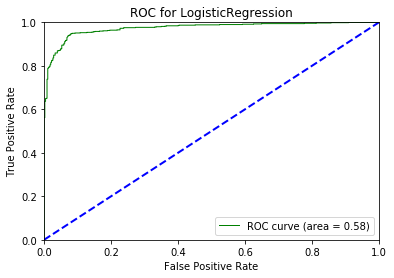

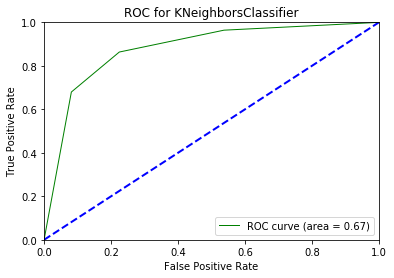

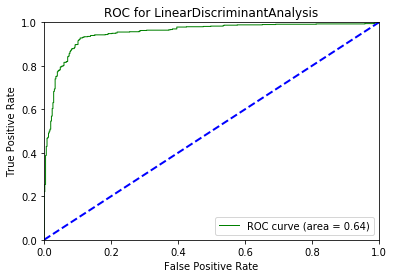

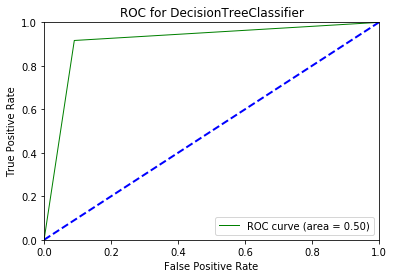

In [79]:
from sklearn.metrics import roc_curve, auc

for model in [lg, knn, lda, dt]:
    probs = model.predict_proba(test.x)
    tpr, fpr, threshold = roc_curve(test.y, probs[:,0])
    plt.figure()
    plt.plot(fpr, tpr, color='green',
             lw=1, label='ROC curve (area = %0.2f)' % auc(test.y, probs[:,0]))
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for {}'.format(str(model).split('(')[0]))
    plt.legend(loc="lower right")
    plt.show()

Obviously the ROC curve for a decision tree will only be a point for a normal decision tree, though we can still calcuate the AUC even with this single point

## Problem 3 [kNN]

Write your own implementation and compare to the library. Split data again
First calculate a distance metric, which is used by a knn

We use OOP concepts of object injection to easily replace distance metrics of the KNN

In [179]:
import math
class Euclidean():
    '''This object will be injected into the classifier in order to calculate distances'''
    def __init__(self):
        pass
    
    def calc(self, x1, x2):
        '''xn can be numpy arrays of numerical values which we will compare the distance of'''
        #basically we square root the sum the difference between them to the power of 2
        #Get the differences
        
        x1 = np.array(x1)
        x2 = np.array(x2)
        
        d = x1 - x2
        
        #square all the elements - elementwise with **
        d = d**2

        return np.sum(d)
        
    
class Knn:
    def __init__(self, k, distance = Euclidean()):
        self.k = int(k)
        self.distmetric = distance
        
    def fit(self, x, y):
        '''As it's a knn, this doesn't do anything but store these values'''
        self.x = np.array(x)
        self.y = np.array(y)
        
    def predict_proba(self, x):
        #sort the points into distance order
        points = np.array(x)
        distances = np.zeros_like(points)
        
        probs = np.zeros(len(points))
        for i in range(len(points)):
            #here we need to generate a classification
            #we want some datatype which has a probability at index i
            dist = np.empty((len(self.x), 2))
            for j in range(len(self.x)):
                #here we want some datatype which is a list of all the distances 
                dist[j,0] = self.distmetric.calc(points[i], self.x[j])
                
                #and keep the class in here too
                dist[j,1] = self.y[j]
            #sort dist by the first axis
            indicies = np.argsort(dist, axis=0)
            
            #get k of these indicies out for their classes, and multiply by 1/k
            
            #here we have the distances of all of the points to all of the training data
            #get the top k
            #weight each of these with 1/k weighting
            temp = self.y[indicies[0:self.k,0]]
            
            probs[i] = np.sum(temp * 1/self.k)
            #use this weight to determine probability of class 1 (we will assume binary classification here)
        #return probabilities that it's in class 1 in a 1d matrix
        return probs
        
    def predict(self, x, threshold = 0.5):
        #use predictproba to do all the real work and set a threshold arbitrarily
        probs = self.predict_proba(x)
        predictions = np.empty_like(x)
        for i in range(len(x)):
            predictions[i] = int(probs[i] > threshold)
        return predictions

models = []
x = np.array([[1, 2, 3], [2, 3, 4], [3, 4, 5]])

y = np.array([1, 0, 1])
knn = Knn(1)
knn.fit(x, y)
knn.predict(np.array([1, 3, 4]))

for i, m in enumerate([Knn, KNeighborsClassifier]):
    kvals = range(1, 30)
    kacc = []
    kerr = []
    for k in kvals:
        model = m(k)
        model.fit(train.x, train.y)

        #Predict and record accuracy metrics

        cm = confusion_matrix(model.predict(test.x), test.y)
        tn, fp, fn, tp = cm.ravel()
        kacc.append((tp+tn)/np.sum(cm.ravel()))
        kerr.append(1-(tp+tn)/np.sum(cm.ravel()))
    models.append(kacc, kerr)

print(models)



ValueError: Classification metrics can't handle a mix of multilabel-indicator and binary targets